<a href="https://colab.research.google.com/github/kylemath/DeepEEG/blob/master/notebooks/DeepEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepEEG

Goal is to make deep learning stacks that processes generally EEG trials as input and predicts binary trial category as output. This is all made to run on Google Colab notebooks using cloud GPU capabilities, so the git repo's get loaded at the start of the code into the workspace. Minor mods may be needed to use local Jupyter notebook. Long term goal of command line interface and mne toolbox plugin.

Strategy:
* Load in Brain Products files with mne, 
* normal pre-processing to get to trials
* Options for frequency or time domain
* Decimate time to reduce features
* Dataset example: P300 during biking outside? 

API:
* Input the data directory and subject numbers of any eeg-notebook experiment (https://github.com/kylemath/eeg-notebooks)
* More general with the master eeg-notebooks - https://github.com/NeuroTechX/eeg-notebooks

LearningModels:
* First try basic Neural Network (NN)
* Then try Convolution Neural Net (CNN)
* Then try Long-Short Term Memory Recurrant Neural Net (LSTM, RNN)

DataModels:
* First pool data over all subjects
* Try subject specific models
* Then try multilevel models

Using: 
* https://github.com/kylemath/eeg-notebooks
* https://github.com/mne-tools/mne-python
* https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
* https://github.com/ml4a/ml4a-guides/blob/master/notebooks/keras_classification.ipynb
* https://github.com/tevisgehr/EEG-Classification

Resources:
* https://arxiv.org/pdf/1901.05498.pdf 
* http://proceedings.mlr.press/v56/Thodoroff16.pdf
*  https://arxiv.org/abs/1511.06448
*  https://github.com/ml4a

In [4]:
!pip install mne
from mne import pick_types, viz, io, Epochs 
from mne import channels, find_events, concatenate_raws
from mne import read_evokeds
from mne.time_frequency import tfr_morlet

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.precision = 4

import numpy as np
from numpy import genfromtxt

from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.layers import Flatten, Conv2D, MaxPooling2D, LSTM
from sklearn.model_selection import train_test_split

#find the factors of a number |to add extra dimension for CNN|
def factors(n):
      return [i for i in range(1, n + 1) if not n%i]


Using TensorFlow backend.


In [6]:
#Parameters#
sub = 104
exp = 'Skateboard'
stance = 'P'
direction = 'CW'
event_ids = ['Standard','Target']
event_nums = [3,5]


  
## For both input types
frequency_domain = 1  #if True uses wavelets otherwise use time series
epoch_decim=1  # to decrease number of time features in time domain

if frequency_domain == 1: #force it
  epoch_decim=1
  wavelet_decim=10 # or in frequency domain

# 'CNN','LSTM','NN'
model_type = 'NN'

print('Parameters Set')

Parameters Set


**Preprocessing of EEG Data**

* LoadData - Each data file is from one session of one subject of the muse cueing task from eeg-notebooks from psych 375 A1 dataset


Extracting parameters from 104_Skateboard_P_CW.vhdr...
Setting channel info structure...
Reading 0 ... 398619  =      0.000 ...   398.619 secs...
Used Annotations descriptions: ['Stimulus/S 41', 'Stimulus/S  1', 'Stimulus/S 61', 'Stimulus/S  5', 'Stimulus/S  3', 'Stimulus/S  9', 'Stimulus/S  7', 'Stimulus/S511']


<ipython-input-19-3f88116a27f2>:4: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  preload=True)
<ipython-input-19-3f88116a27f2>:4: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True)


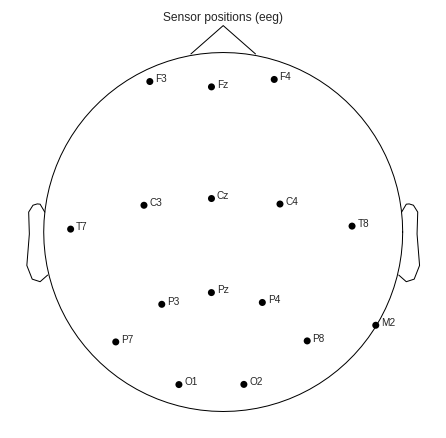

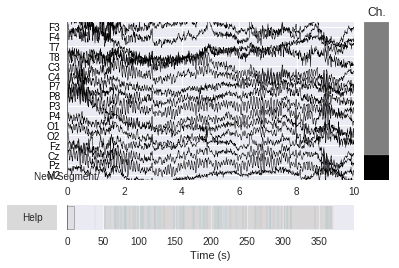

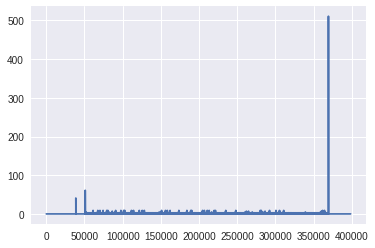

In [19]:
raw = io.read_raw_brainvision(str(sub) + '_' + exp + '_' + stance + '_' + direction + '.vhdr', 
                              montage='standard_1020', 
                              eog=('HEOG', 'VEOG'), 
                              preload=True)

#set sampling rate
sfreq = raw.info['sfreq']
nsfreq = sfreq/epoch_decim #create new output freq for after epoch or wavelet decim

#load channel locations
raw.plot_sensors(show_names='True')


#Consider rereferencing to linked mastoids?
        ## arithmetically rereference to linked mastoid
        #for x=1:EEG.nbchan-2
        #    EEG.data(x,:) = (EEG.data(x,:)-((EEG.data(EEG.nbchan-2,:))*.5));
        #end
 #raw.set_eeg_reference(ref_channels=['M2'])  # set EEG reference to channel


raw.plot(n_channels=16, block=True)

#stim channel (remove for machine learning)
plt.plot(raw._data[18])


* Filtering - Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.


Effective window size : 2.048 (s)


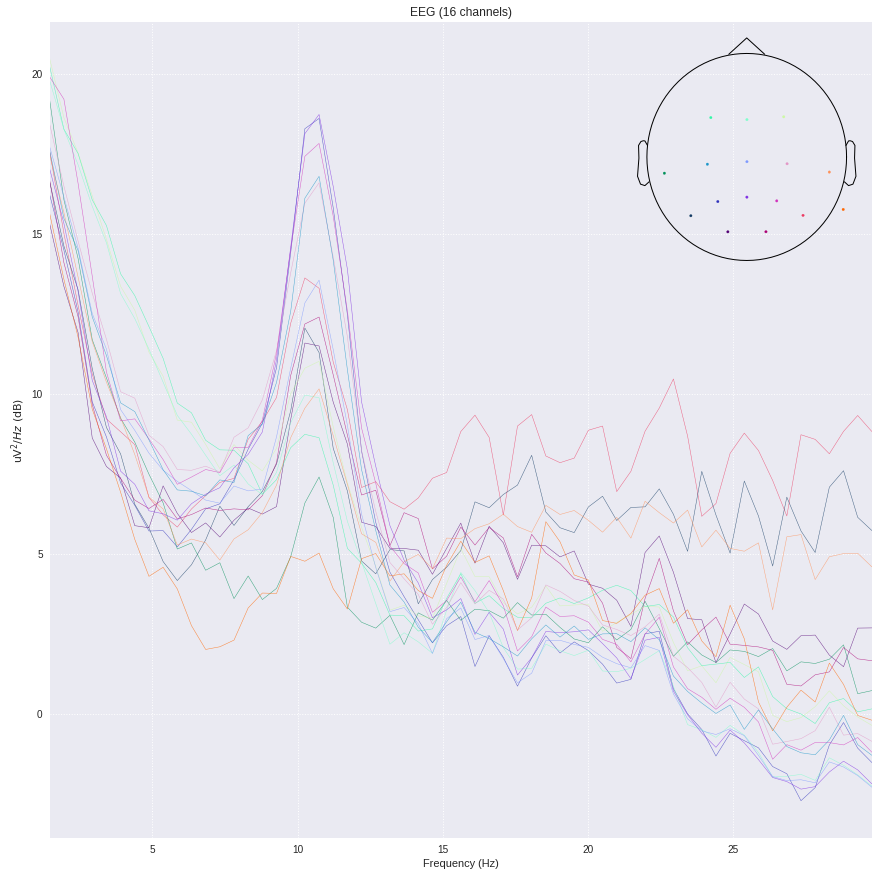

Filtering Data
Effective window size : 2.048 (s)


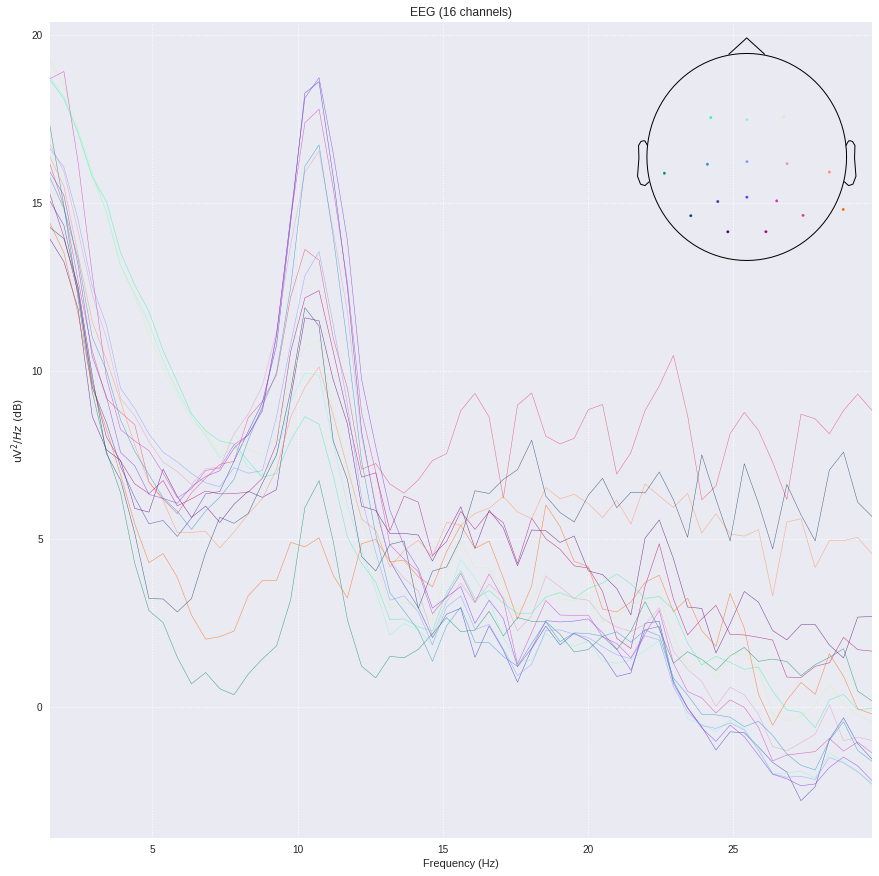

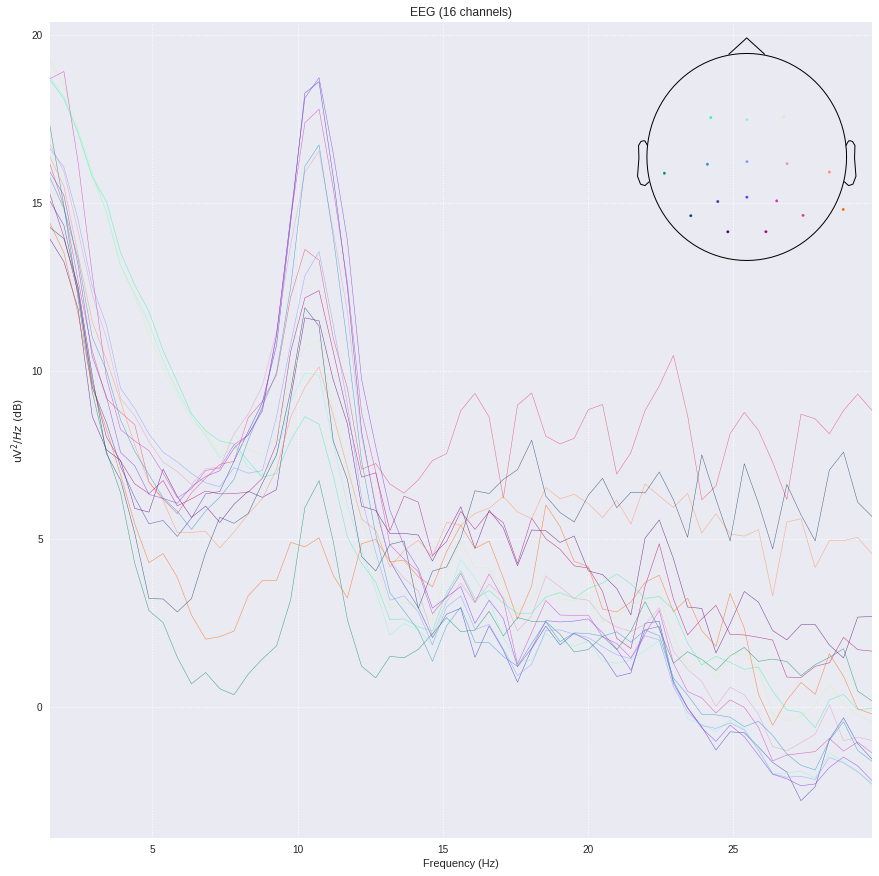

In [8]:
#filter
eeg_filter_highpass = 1
eeg_filter_lowpass = nsfreq/2.5  #lower to avoid aliasing from decim

raw.plot_psd(fmin=eeg_filter_highpass, fmax=30 ) 

#Filtering
print('Filtering Data')
raw.filter(eeg_filter_highpass,eeg_filter_lowpass, method='iir', verbose='WARNING' )

#Plot filtred data spectra if desired
raw.plot_psd(fmin=eeg_filter_highpass, fmax=30 ) 


* Epoching - Next, we will chunk (epoch) the data into segments representing the data 1000ms before to 2000ms after each cue, we will reject every epoch where the amplitude of the signal exceeded 100 uV, which should most eye blinks.

584 events found
Event IDs: [  1   3   5   7   9  41  61 511]


<ipython-input-10-77da3a3a8c95>:14: RuntimeWarning: event 1 missing from event_id will be ignored
  event_id=event_id)
<ipython-input-10-77da3a3a8c95>:14: RuntimeWarning: event 7 missing from event_id will be ignored
  event_id=event_id)
<ipython-input-10-77da3a3a8c95>:14: RuntimeWarning: event 9 missing from event_id will be ignored
  event_id=event_id)
<ipython-input-10-77da3a3a8c95>:14: RuntimeWarning: event 41 missing from event_id will be ignored
  event_id=event_id)
<ipython-input-10-77da3a3a8c95>:14: RuntimeWarning: event 61 missing from event_id will be ignored
  event_id=event_id)
<ipython-input-10-77da3a3a8c95>:14: RuntimeWarning: event 511 missing from event_id will be ignored
  event_id=event_id)


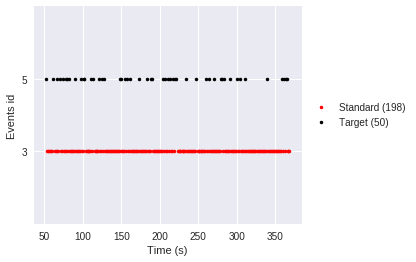

sample drop %:  57.53424657534247


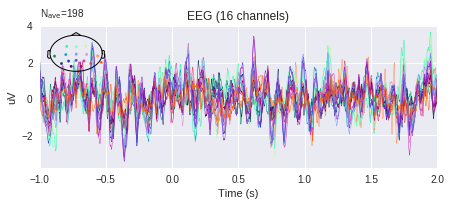

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


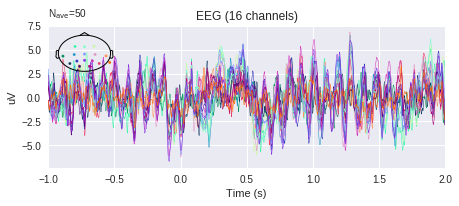

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


{'Standard': <Evoked  |  'Standard' (mean, N=198), [-1, 2] sec, 16 ch, ~421 kB>, 'Target': <Evoked  |  'Target' (mean, N=50), [-1, 2] sec, 16 ch, ~421 kB>}
14


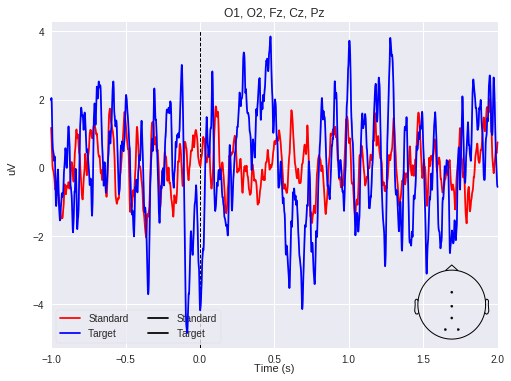

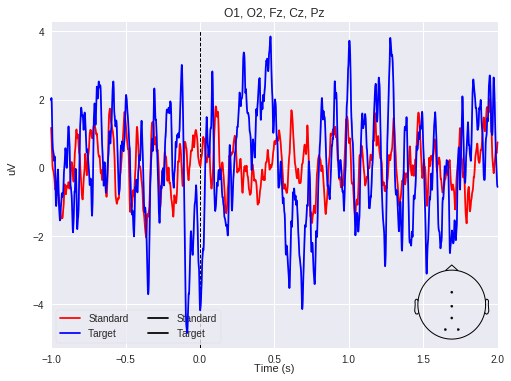

In [10]:
#Time limits for epochs
tmin=-1 #-1
tmax=2 #2
baseline=(-1, 0) #None or (start, end) in seconds

#artifact rejection
rej_thresh_uV = 500 #300 removes most blinks, 1000 keeps most trials
rej_thresh = rej_thresh_uV*1e-6

#Epoching
event_id = {event_ids[0]: event_nums[0], event_ids[1]: event_nums[1]} #create dict
events = find_events(raw,shortest_event=1)
color = {event_nums[0]: 'red', event_nums[1]: 'black'}
viz.plot_events(events, sfreq, raw.first_samp, color=color,
                    event_id=event_id)


epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=tmin, tmax=tmax, baseline=baseline, 
                preload=True,reject={'eeg':rej_thresh},
                verbose=False, decim=epoch_decim)


print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
%matplotlib inline
conditions = OrderedDict()
conditions[event_ids[0]] = [1]
conditions[event_ids[1]] = [2]


## plot ERP on each trial
evoked_standard = epochs['Standard'].average()
evoked_target = epochs['Target'].average()
pick = pick_types(evoked_target.info, meg=False, eeg=True, eog=False)
fig_stand =evoked_standard.plot(spatial_colors=True, picks=pick)
fig_stand.tight_layout()
fig_targ = evoked_target.plot(spatial_colors=True, picks=pick)
fig_targ.tight_layout()



## plot ERP in each condition on same plot
conditions = ["Standard", "Target"]
evoked_dict = dict()
evoked_dict["Standard"] = evoked_standard
evoked_dict["Target"] = evoked_target
print(evoked_dict)

colors = dict(Standard="Red", Target="Blue")
linestyles = dict(Standard='-', Target='-')
pick = evoked_dict["Standard"].ch_names.index('Pz')
print(pick)
viz.plot_compare_evokeds(evoked_dict, picks=[10,11,12,13,14], colors=colors,
                             linestyles=linestyles, split_legend=True)


** Spectrogram **

* All electrodes are considered on each trial
* Many frequencies are used in the wavelet analysis while the output of the morlet is decimated in time.
* Two conditions are done separate and concatenated
* X is a trials x freq x time matrix
* Y is a trials array of condition labels (turned into one hot vectors later in code)


In [12]:
if frequency_domain:
  #wavelet settings
  f_low = 4
  f_high = 40
  f_bins = 20  # to decrease number of frequency features
  wave_cycles = 6 # cycles of each frequency to convolve with data
  spect_baseline = [-1,-.5] #gets removed from training data but used during processing
  electrodes_out = pick_types(evoked_target.info, meg=False, eeg=True, eog=False)
  electrodes_out = [11,12,13,14,15]

  frequencies =  np.linspace(f_low, f_high, f_bins, endpoint=True)

  
  # Condition0
  print('Computing Morlet Wavelets on ' + event_ids[0])

  tfr0 = tfr_morlet(epochs[event_ids[0]], freqs=frequencies, 
                        n_cycles=wave_cycles, return_itc=False,
                        picks=electrodes_out,average=False,decim=wavelet_decim)
  tfr0 = tfr0.apply_baseline(spect_baseline,mode='mean')
  stim_onset = np.argmax(tfr0.times>0)
  new_times = tfr0.times[stim_onset:]

  #reshape data
  cond0_power_out = np.moveaxis(tfr0.data[:,:,:,stim_onset:],1,3) #move electrodes last
  cond0_power_out = np.moveaxis(cond0_power_out,1,2) # move time second
  #cond0_power_out[:,0:5,0:5,:] = 0 #for testing model add mark to image

  print('Condition zero trials: ' + str(len(cond0_power_out)))

  print(event_ids[0] + ' Time Points: ' + str(len(new_times)))
  print(event_ids[0] + ' Frequencies: ' + str(len(tfr0.freqs)))

  #Condition1
  print('Computing Morlet Wavelets on ' + event_ids[1])
  tfr1 = tfr_morlet(epochs[event_ids[1]], freqs=frequencies, 
                        n_cycles=wave_cycles, return_itc=False,
                        picks=electrodes_out,average=False,decim=wavelet_decim)
  tfr1 = tfr1.apply_baseline(spect_baseline,mode='mean')
  
  #reshape data
  cond1_power_out = np.moveaxis(tfr1.data[:,:,:,stim_onset:],1,3)
  cond1_power_out = np.moveaxis(cond1_power_out,1,2) # move time second
  #cond1_power_out[:,0:5,0:5,:] = 1 #for testing model add mark to image

  print('Condition one trials: ' + str(len(cond1_power_out)))    

  print(event_ids[1] + ' Time Points: ' + str(len(new_times)))
  print(event_ids[1] + ' Frequencies: ' + str(len(tfr1.freqs)))
  X = np.append(cond0_power_out,cond1_power_out,0);
  
  if model_type != 'CNN':
    #reshape to trials x times x variables for LSTM and NN model
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2] * X.shape[3]),order='F')
   
  #Normalize X - need to save mean and std for future test + val
  X = (X - np.mean(X)) / np.std(X)
  
  #Append Data
  Y_class = np.append(np.zeros(len(cond0_power_out)), np.ones(len(cond1_power_out)),0)
  
  print('Combined X Shape: ' + str(X.shape))
  print('Combined Y Shape: ' + str(Y_class.shape))

Computing Morlet Wavelets on Standard
Applying baseline correction (mode: mean)
Condition zero trials: 198
Standard Time Points: 200
Standard Frequencies: 20
Computing Morlet Wavelets on Target
Applying baseline correction (mode: mean)
Condition one trials: 50
Target Time Points: 200
Target Frequencies: 20
Combined X Shape: (248, 200, 100)
Combined Y Shape: (248,)


**Time Domain**

* Instead may want to retain time domain data
* After Epoching, arange data into useful format with labels

In [0]:
if not frequency_domain:
  X = np.moveaxis(epochs._data[:,:-3,:],1,2); #put channels last, remove eye and stim
  
  
  #take post baseline only
  stim_onset = np.argmax(epochs.times>0)
  new_times = epochs.times[stim_onset:]
  X = X[:,stim_onset:,:]
  
  print(X.shape)
  if model_type == 'CNN' and not frequency_domain:
    # reshape for CNN 512 ms long, factors 64 * 8
    # these 10's need to be found algorithmically (find any factor of the number)
    all_factors = factors(X.shape[1])
    X = np.reshape(X, (X.shape[0], int(X.shape[1]/all_factors[2]), all_factors[2], X.shape[2]),order='F')
    
  #Normalize X - need to save mean and std for future test + val
  #X = (X - np.mean(X)) / np.std(X)
  
  Y_class = ((epochs.events[:,2]-1)/2)-1  #subtract 1 to make 0 and 1
  
  print('X Shape: ' + str(X.shape))
  print('Y Shape: ' + str(Y_class.shape))
  print('Y Example: ' + str(Y_class[0:10]))

**Prepare Data for Model**


In [13]:
#Training Settings


test_split = 0.2
val_split = 0.2
num_classes = len(event_ids)
random_seed = 1017
np.random.seed(random_seed)

# convert class vectors to one hot Y and recast X
Y = keras.utils.to_categorical(Y_class, num_classes)
X = X.astype('float32')

# Split training test and validation data 
val_prop = val_split / (1-test_split)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_prop, random_state=random_seed)

# Compute model input shape
input_shape = X.shape[1:]


print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
print('X Examples:')

#for plotting

vmin = (np.std(X)/4) * -1
vmax = np.std(X)/4  

#Plot Example Data
#f, axarr = plt.subplots(2,2, figsize = (8,8))
#axarr[0][0].set_title(event_ids[0])
#axarr[0][0].imshow(X[0],vmin=vmin, vmax=vmax, aspect='auto')

#axarr[0][0].invert_yaxis()
#axarr[1][0].imshow(X[1],vmin=vmin, vmax=vmax, aspect='auto')
#axarr[1][0].invert_yaxis()

#axarr[0][1].set_title(event_ids[1])
#axarr[0][1].imshow(X[-1],vmin=vmin, vmax=vmax, aspect='auto')
#axarr[0][1].invert_yaxis()
#axarr[1][1].imshow(X[-2],vmin=vmin, vmax=vmax, aspect='auto')
#axarr[1][1].invert_yaxis()
;

print('Input Shape: ' + str(input_shape))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')


X Range: -23.651625:37.313175
X Examples:
Input Shape: (200, 100)
x_train shape: (148, 200, 100)
148 train samples
50 test samples
50 validation samples


**Build Model and Train**

Running NN Model:
Train on 148 samples, validate on 50 samples
Epoch 1/20
148/148 [==============================] - 0s 3ms/step - loss: 1.5199 - acc: 0.6216 - val_loss: 1.2020 - val_acc: 0.7400
Epoch 2/20
148/148 [==============================] - 0s 1ms/step - loss: 0.8412 - acc: 0.7432 - val_loss: 0.9852 - val_acc: 0.7800
Epoch 3/20
148/148 [==============================] - 0s 1ms/step - loss: 0.8431 - acc: 0.7162 - val_loss: 1.1200 - val_acc: 0.7800
Epoch 4/20
148/148 [==============================] - 0s 1ms/step - loss: 0.7937 - acc: 0.7432 - val_loss: 0.8292 - val_acc: 0.7400
Epoch 5/20
148/148 [==============================] - 0s 1ms/step - loss: 0.6965 - acc: 0.7162 - val_loss: 1.8203 - val_acc: 0.6000
Epoch 6/20
148/148 [==============================] - 0s 1ms/step - loss: 0.9020 - acc: 0.7230 - val_loss: 1.0967 - val_acc: 0.7400
Epoch 7/20
148/148 [==============================] - 0s 1ms/step - loss: 0.9927 - acc: 0.7365 - val_loss: 1.1589 - val_acc: 0.8000
Epoch 8/20
14

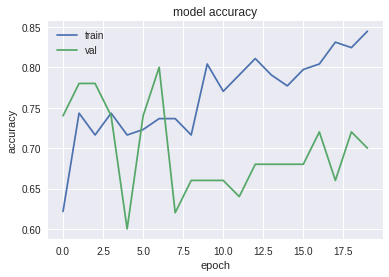

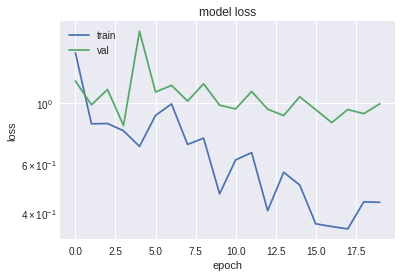

50/50 [==============================] - 0s 680us/step
Test score: 1.0003099605441093
Test accuracy: 0.7400000154972076


In [15]:
print('Running ' +  model_type + ' Model:')
batch_size = 5
train_epochs = 20
  
if model_type == 'LSTM':
  ##---LSTM - Many to two, sequence of time to classes
  units = [input_shape[1], 4, 4, num_classes]
  model = Sequential()
  model.add(LSTM(input_shape=(None, units[0]) ,units=units[1], return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=units[2],return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(units=units[3]))
  model.add(Activation("softmax"))

if model_type == 'NN':
  ##---DenseFeedforward Network
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(4, activation='relu'))
  model.add(Dropout(.20))
  model.add(Dense(4, activation='relu'))
  model.add(Dropout(.20))
  model.add(Dense(num_classes, activation='softmax'))

if model_type == 'CNN':
  ##----Convolutional Network
  model = Sequential()
  model.add(Conv2D(10, (3, 3), input_shape=input_shape, padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  
# initiate adam optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#Train Model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=train_epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          verbose=True)
         
#Summarize
model.summary()
 

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test on left out Test data
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)